Iter 100, Loss: 5.13122e-02, Loss_u: 3.66562e-02, Loss_f: 1.46559e-02
Iter 200, Loss: 2.54234e-02, Loss_u: 1.19843e-02, Loss_f: 1.34391e-02
Iter 300, Loss: 1.22146e-02, Loss_u: 7.10974e-03, Loss_f: 5.10486e-03
Iter 400, Loss: 6.44058e-03, Loss_u: 4.25439e-03, Loss_f: 2.18618e-03
Iter 500, Loss: 3.80752e-03, Loss_u: 1.92918e-03, Loss_f: 1.87834e-03
Iter 600, Loss: 2.65497e-03, Loss_u: 1.21517e-03, Loss_f: 1.43980e-03
Iter 700, Loss: 1.84519e-03, Loss_u: 8.91892e-04, Loss_f: 9.53301e-04
Iter 800, Loss: 1.30438e-03, Loss_u: 6.05930e-04, Loss_f: 6.98451e-04
Iter 900, Loss: 1.01574e-03, Loss_u: 5.04434e-04, Loss_f: 5.11308e-04
Iter 1000, Loss: 7.87737e-04, Loss_u: 3.27585e-04, Loss_f: 4.60153e-04
Iter 1100, Loss: 5.86049e-04, Loss_u: 2.15457e-04, Loss_f: 3.70592e-04
Iter 1200, Loss: 4.36875e-04, Loss_u: 1.37473e-04, Loss_f: 2.99402e-04
Iter 1300, Loss: 3.47964e-04, Loss_u: 9.33607e-05, Loss_f: 2.54603e-04
Iter 1400, Loss: 2.94749e-04, Loss_u: 9.83997e-05, Loss_f: 1.96349e-04
Iter 1500, Loss

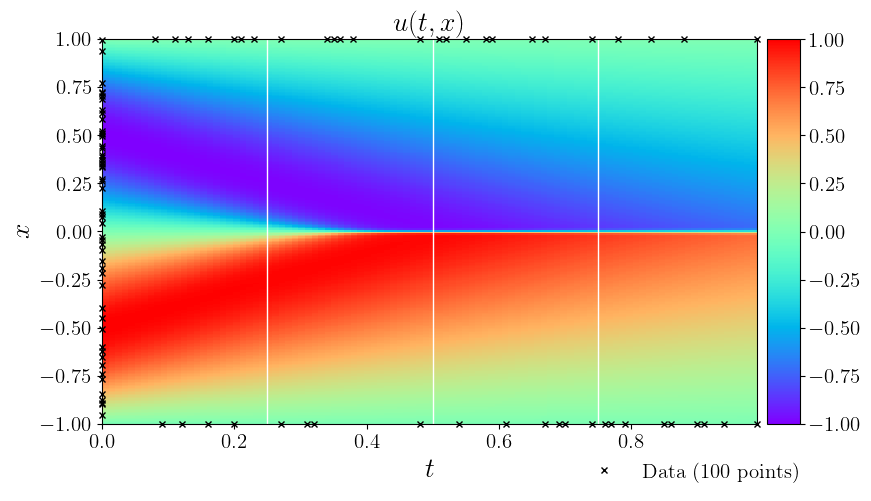

In [2]:
import sys
sys.path.insert(0, './Utilities/')

import torch
from collections import OrderedDict

from pyDOE import lhs
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time

np.random.seed(1234)

# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

#ネットーワーク構造の定義
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

#PINNの定義
class PhysicsInformedNN():
    def __init__(self, X_u, u, X_f, layers, lb, ub, nu):
        
        # boundary conditions
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        
        self.layers = layers
        self.nu = nu
        
        # deep neural networks
        self.dnn = DNN(layers).to(device)
        
        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )

        self.iter = 0
        
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))
        return u
    
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t + u * u_x - self.nu * u_xx
        return f
    
    def loss_func(self):
        self.optimizer.zero_grad()
        
        u_pred = self.net_u(self.x_u, self.t_u)
        f_pred = self.net_f(self.x_f, self.t_f)
        loss_u = torch.mean((self.u - u_pred) ** 2)
        loss_f = torch.mean(f_pred ** 2)
        
        loss = loss_u + loss_f
        
        loss.backward()
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_u.item(), loss_f.item())
            )
        return loss
    
    def train(self):
        self.dnn.train()
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)

            
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, t)
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

nu = 0.01/np.pi
noise = 0.0        

N_u = 100
N_f = 10000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

data = scipy.io.loadmat('data/burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)    

xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
uu1 = Exact[0:1,:].T
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
uu2 = Exact[:,0:1]
xx3 = np.hstack((X[:,-1:], T[:,-1:]))
uu3 = Exact[:,-1:]

X_u_train = np.vstack([xx1, xx2, xx3])
X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))
u_train = np.vstack([uu1, uu2, uu3])

idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]

model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, nu)

model.train()

u_pred, f_pred = model.predict(X_star)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
Error = np.abs(Exact - U_pred)


""" The aesthetic setting has changed. """

####### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_u_train[:,1], 
    X_u_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()

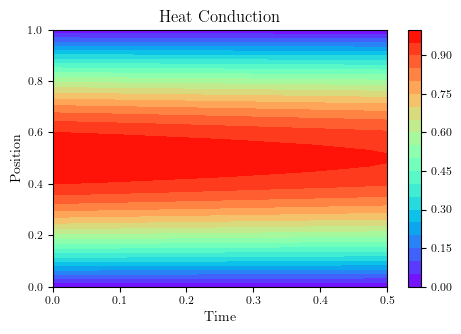

In [4]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

# 熱伝導方程式の解を計算する関数
def solve_heat_conduction(nx, nt, L, T, alpha):
    dx = L / (nx - 1)
    dt = T / (nt - 1)
    
    x = np.linspace(0, L, nx)
    t = np.linspace(0, T, nt)
    
    u = np.zeros((nt, nx))
    
    # 初期条件: u(x, 0) = sin(pi * x / L)
    u[0, :] = np.sin(np.pi * x / L)
    
    # 境界条件: u(0, t) = u(L, t) = 0
    for n in range(0, nt-1):
        for i in range(1, nx-1):
            u[n+1, i] = u[n, i] + alpha * dt / dx**2 * (u[n, i-1] - 2*u[n, i] + u[n, i+1])
    
    return x, t, u

# パラメータの設定
L = 1.0      # 材料の長さ
T = 0.5      # 時間の長さ
alpha = 0.01 # 熱拡散係数
nx = 50      # 空間ステップ数
nt = 100     # 時間ステップ数

# 熱伝導方程式を解く
x, t, u = solve_heat_conduction(nx, nt, L, T, alpha)

# データをプロット
X, T = np.meshgrid(x, t)
plt.figure()
plt.contourf(T, X, u, 20, cmap='rainbow')
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Heat Conduction')
plt.show()

# データを保存
data = {'x': x, 't': t, 'usol': u}
scipy.io.savemat('heat_conduction.mat', data)

In [6]:
import sys
sys.path.insert(0, './Utilities/')

import torch
from collections import OrderedDict

from pyDOE import lhs
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time

np.random.seed(1234)

# CUDAのサポート
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# ネットワーク構造の定義
#TODO1:熱伝達方程式の解に対応したネットワーク構造を定義
#TODO2:対流熱伝達係数を入力に受け取るようにネットワーク構造を変更
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # パラメータ
        self.depth = len(layers) - 1
        
        # レイヤー順序の設定
        self.activation = torch.nn.ELU
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1])))
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1])))
        layerDict = OrderedDict(layer_list)
        
        # レイヤーの展開
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

# 物理インフォームドニューラルネットワーク（PINN）の定義
class PhysicsInformedNN():
    def __init__(self, X_u, u, X_f, layers, lb, ub, k, rho, cp, alpha, h1, h2, T_inf):
        
        # 境界条件
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        # データ
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        
        self.layers = layers
        
        #新しく追加
        self.k = k
        self.rho = rho
        self.alpha = alpha
        self.h1 = h1
        self.h2 = h2
        self.T_inf = T_inf
        # self.lambda0 = lambda0
        # self.lambda1 = lambda1
        # self.lambda2 = lambda2
        
        # 深層ニューラルネットワーク
        self.dnn = DNN(layers).to(device)
        
        # オプティマイザー: 同じ設定を使用
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"
        )

        self.iter = 0
        
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))
        return u
    
    #熱伝導方程式の残差を計算
    def net_f(self, x, t):
        """ PyTorchのautogradを用いて残差を計算 """
        u = self.net_u(x, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t - self.alpha * u_xx
        return f
    
    #追加：境界条件の残差①を計算
    def net_BC1(self, x, t):
        """ 境界条件の残差を計算 """
        u = self.net_u(x, t)
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        BC1 = self.T_inf - u + (self.k / self.h1) * u_x
        return BC1

    #追加：境界条件の残差②を計算
    def net_BC2(self, x, t):
        """ 境界条件の残差を計算 """
        u = self.net_u(x, t)
        u_x = torch.autograd.grad(
            u, x,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        BC2 = self.T_inf - u - (self.k / self.h2) * u_x
        return BC2
    
    def loss_func(self):
        self.optimizer.zero_grad()
        
        u_pred = self.net_u(self.x_u, self.t_u)
        f_pred = self.net_f(self.x_f, self.t_f)

        #追加:境界条件の予測
        BC1_pred = self.net_BC1(self.x_u, self.t_u) # 境界条件1の誤差を計算
        BC2_pred = self.net_BC2(self.x_u, self.t_u) # 境界条件2の誤差を計算

        loss_u = torch.mean((self.u - u_pred) ** 2)
        loss_f = torch.mean(f_pred ** 2)
        
        #追加:境界条件の誤差
        loss_BC1 = torch.mean(BC1_pred ** 2)
        loss_BC2 = torch.mean(BC2_pred ** 2)
        
        #TODO3:損失関数のに重み付けを追加
        # loss = (1 / len(f_pred)) * loss_f + self.lambda0 * loss_u + self.lambda1 * loss_BC1 + self.lambda2 * loss_BC2
        loss = loss_u + loss_f + loss_BC1 + loss_BC2
        
        loss.backward()
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_u.item(), loss_f.item())
            )
        return loss
    
    def train(self):
        self.dnn.train()
                
        # 逆伝播と最適化
        self.optimizer.step(self.loss_func)

            
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, t)
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

# k = 0.01  # 熱伝達係数
# alpha=0.01 # 熱拡散係数
k = 0.01
rho = 1.0
cp = 1.0
alpha = k / (rho * cp)
noise = 0.0

h1 = 0.01
h2 = 0.01
T_inf = 50

#TODO4：損失関数の重み付け
#lambda0, lambda1, lambda2 = 1.0, 1.0, 1.0 

N_u = 100
N_f = 10000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

# データの読み込み
data = scipy.io.loadmat('data/heat_conduction.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# ドメインの境界
lb = X_star.min(0)
ub = X_star.max(0)    

xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
uu1 = Exact[0:1,:].T
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
uu2 = Exact[:,0:1]
xx3 = np.hstack((X[:,-1:], T[:,-1:]))
uu3 = Exact[:,-1:]

X_u_train = np.vstack([xx1, xx2, xx3])
X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))
u_train = np.vstack([uu1, uu2, uu3])

idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]

# モデルのインスタンス化
model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, alpha)

# モデルのトレーニング
model.train()

# 予測
u_pred, f_pred = model.predict(X_star)

# 誤差の計算
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
Error = np.abs(Exact - U_pred)

# 可視化
# fig = plt.figure(figsize=(9, 5))
# ax = fig.add_subplot(111)

# h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
#               extent=[t.min(), t.max(), x.min(), x.max()], 
#               origin='lower', aspect='auto')
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.10)
# cbar = fig.colorbar(h, cax=cax)
# cbar.ax.tick_params(labelsize=15) 

# ax.plot(
#     X_u_train[:,1], 
#     X_u_train[:,0], 
#     'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
#     markersize = 4, 
#     clip_on = False,
#     alpha=1.0
# )

# line = np.linspace(x.min(), x.max(), 2)[:,None]
# ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
# ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
# ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

# ax.set_xlabel('$t$', size=20)
# ax.set_ylabel('$x$', size=20)
# ax.legend(
#     loc='upper center', 
#     bbox_to_anchor=(0.9, -0.05), 
#     ncol=5, 
#     frameon=False, 
#     prop={'size': 15}
# )
# ax.set_title('$u(t,x)$', fontsize = 20)
# ax.tick_params(labelsize=15)

# plt.show()

IndexError: index 216 is out of bounds for axis 0 with size 200